In [1]:
# Load modules
import sys
sys.path.append('../utilities_tlezuo/')

import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import xarray as xr
from matplotlib import cm

from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import datetime as dt

from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
###############################################################################################
## CONSTANT FILE  ##
c_filename = "lfff00000000c.nc"
filepath = '/store/s83/swester/teamx/tdf_2019091212/output/19091212/'
const_file = filepath + c_filename
data_c = psy.open_dataset(const_file)

###############################################################################################
## DECIDE ##
# where to save
loadpath = '/users/tlezuo/icon-vis/height_time_diagrams/data/'
# decide which locations to calculate
loc_list = []
# loc_list.extend([])
loc_list=[lf.kols]

# decide which variables to calculate
pvars_list = []
# pvars_list.extend([vf.qv_2m,vf.T_2M])
pvars_list= [vf.U, vf.V, vf.T, vf.QV,vf.P,vf.VEL,vf.DIR]

###############################################################################################
## DATELISTS ##
# ICON model: as writeout times: 30 min
startdate_model = dt.datetime(2019,9,12,12,00)
enddate_model = dt.datetime(2019,9,14,00,00)
plotdates_model = pd.date_range(startdate_model,enddate_model,freq='0h30min')
# radiosoundings: 3h and 2h intervals
plotdates_rs = [dt.datetime(2019,9,12,23,00),dt.datetime(2019,9,13,3,00),dt.datetime(2019,9,13,6,00),dt.datetime(2019,9,13,9,00),
dt.datetime(2019,9,13,11,00),dt.datetime(2019,9,13,13,00),dt.datetime(2019,9,13,15,00),dt.datetime(2019,9,13,17,00),dt.datetime(2019,9,13,20,00),dt.datetime(2019,9,13,23,00)]
# lidar SR88: 10 min
plotdates_lidar = pd.date_range(startdate_model,enddate_model,freq='0h10min')


In [3]:
## LOAD DATA ##
loc=lf.kols
# ICON model
htd_data_model = np.load(loadpath+'htd_ICON_'+loc.name+'.npy',allow_pickle='TRUE').item()
# radiosoundings
htd_data_rs = np.load(loadpath+'htd_rs_Kolsass.npy',allow_pickle='TRUE').item()
# Streamline Lidar SR88
htd_data_lidar_SL88 = xr.open_dataset(loadpath+'htd_lidar_SL88_Kolsass.nc').load()
htd_data_lidar_SL88 = htd_data_lidar_SL88.transpose()
# Streamline Lidar SLXR142
htd_data_lidar_SLXR142 = xr.open_dataset(loadpath+'htd_lidar_SLXR142_Kolsass.nc').load()
# HATPRO Lidar
htd_data_lidar_hatpro = xr.open_dataset(loadpath+'htd_lidar_hatpro_Kolsass.nc').load()
htd_data_lidar_hatpro = htd_data_lidar_hatpro.transpose()

FileNotFoundError: [Errno 2] No such file or directory: '/users/tlezuo/icon-vis/height_time_diagrams/data/htd_ICON_Kolsass.npy'

/scratch/tlezuo/miniconda3/envs/psyplot/lib/python3.9/site-packages/numpy/ma/core.py:2358: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = np.array(a, copy=copy, subok=True)


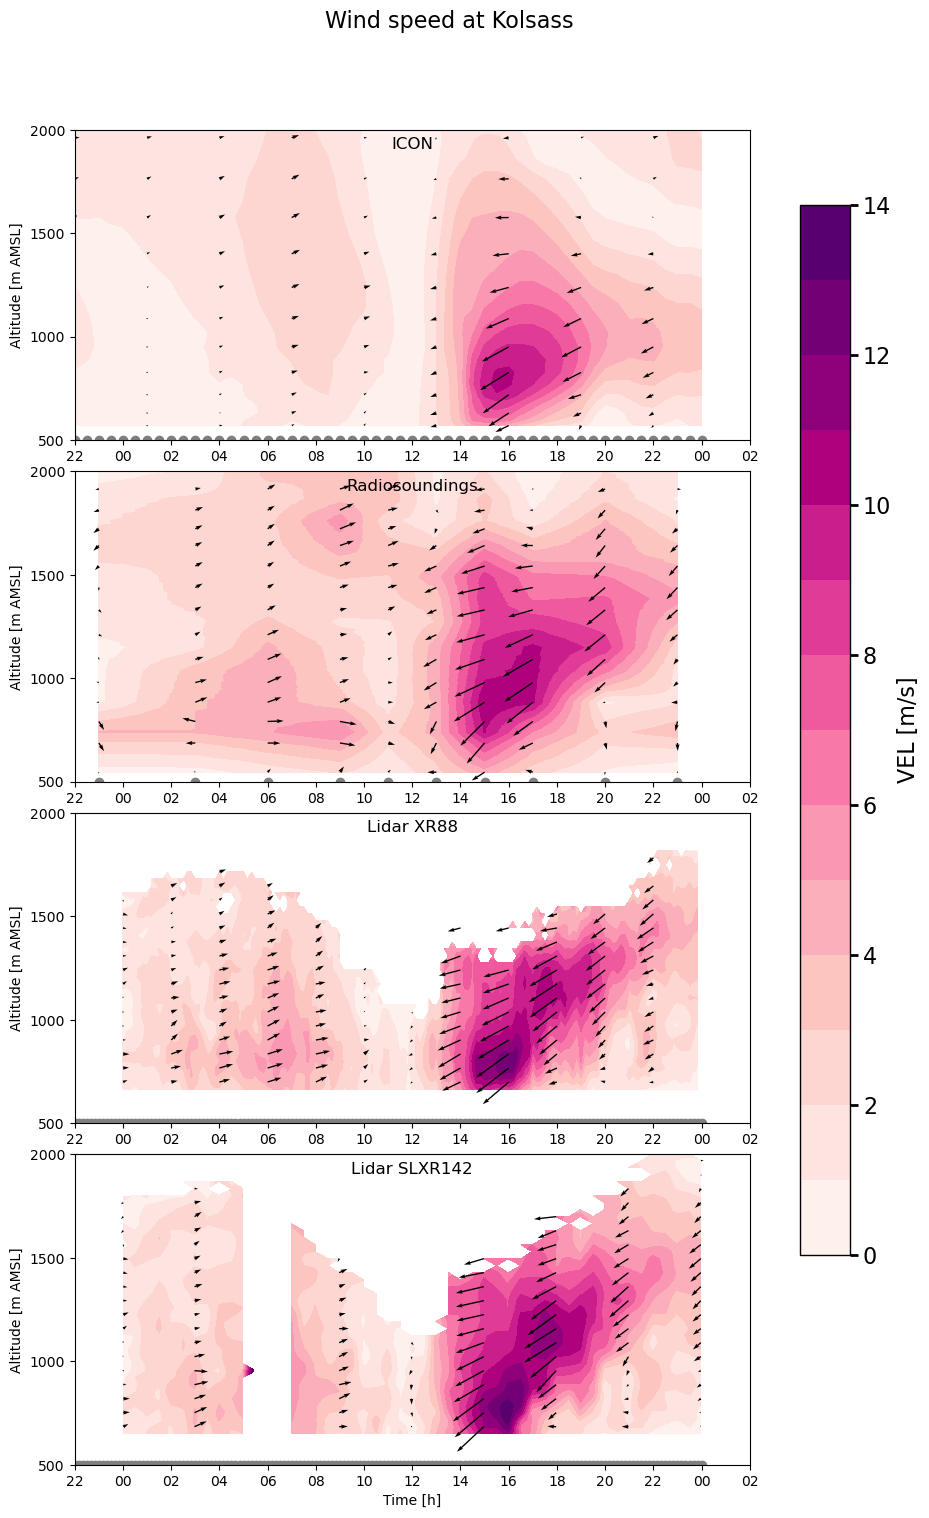

In [ ]:
## PLOT 4 LIDAR PLOT MODEL + RS + 2 LIDARS ##
# with windbarbs at personalized locations
# select variable
pvar=vf.VEL

# vertical range
zmin = 500
zmax = 2000
altitudes = np.arange(500,2001,500)

# time range
startdate_plot = dt.datetime(2019,9,12,22,00)
enddate_plot = dt.datetime(2019,9,14,2,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# colorscale levels
levels = np.arange(pvar.min,pvar.max,pvar.ticks)
# h2500
if zmax == 2000:
        if pvar.name == 'T':
                levels = np.arange(285,306,2)
        if pvar.name == 'VEL':
                levels = np.arange(0,15,1)

# figure settings
fig, (ax1, ax2, ax3,ax4) = plt.subplots(4,1, figsize=(10,15))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9,hspace=0.1)
fig.suptitle(pvar.title+' at '+loc.name, fontsize=16)

# windbarb settings
q_scale = 30
q_width = 0.002

##################################################################################################
## MODEL ##
x1 = plotdates_model
if pvar.modlev == 80:
        y1 = htd_data_model['HFL_loc']
elif pvar.modlev == 81:
        y1 = htd_data_model['HHL_loc']
y1_wind=htd_data_model['HFL_loc']
z1 = np.transpose(htd_data_model[pvar.name])
u1 = np.transpose(htd_data_model['U'])
v1 = np.transpose(htd_data_model['V'])

# data for windbarbs only at sounding timesteps
x_w =pd.DatetimeIndex(['2019-09-13 03:00:00','2019-09-13 06:00:00','2019-09-13 09:00:00','2019-09-13 11:00:00',
'2019-09-13 13:00:00','2019-09-13 15:00:00','2019-09-13 17:00:00','2019-09-13 20:00:00','2019-09-13 23:00:00'],
dtype='datetime64[ns]', freq=None) 
y_w = y1
z_w = z1[[5,11,17,21,25,29,33,39,45],:]
u_w = u1[[5,11,17,21,25,29,33,39,45],:]
v_w = v1[[5,11,17,21,25,29,33,39,45],:]

#create plot
# colormap
cf = ax1.contourf(x1,y1,z1, levels = levels, cmap=pvar.cmap)
# windbarbs
dx1 = 6 # dx/2= hours for model
dy1 = 2
ax1.quiver(x1[2::dx1], y1_wind[::dy1], u1[::dy1, 2::dx1], v1[::dy1, 2::dx1], 
        scale=q_scale, scale_units='inches', width=q_width)   
# ax1.quiver(x_w[2::dx], y[::dy], u[::dy, 2::dx], v[::dy, 2::dx], 
#         scale=q_scale, scale_units='inches', width=q_width)   
# ax1.quiver(x_w, y_w[::dy], u_w[::dy, :], v_w[::dy, :], 
#         scale=q_scale, scale_units='inches', width=q_width)    
# datapoints
ax1.scatter(plotdates_model,np.full((len(plotdates_model),1),500),color='grey')

# plotting options
ax1.set_ylim(zmin,zmax)
ax1.set_xlim(startdate_plot,enddate_plot)
# ax1.grid()
ax1.set_title('ICON', y=1.0, pad=-14)
# ax1.set_xlabel('Time [h]')
ax1.set_xticks(plotdates_plot)
ax1.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax1.set_ylabel('Altitude [m AMSL]')
ax1.set_yticks(altitudes)

##################################################################################################
## OBS RS ##
# set data
x2 = plotdates_rs
y2 = htd_data_rs['ALT'][0]
z2 = np.transpose(htd_data_rs[pvar.name])
u2 = np.transpose(htd_data_rs['U'])
v2 = np.transpose(htd_data_rs['V'])

#create plot
# colormap
cf = ax2.contourf(x2,y2,z2, levels = levels, cmap=pvar.cmap)
# windbarbs 
dy2 = 10 # large distance for rs
ax2.quiver(x2, y2[::dy2], u2[::dy2, :], v2[::dy2, :], 
        scale=q_scale, scale_units='inches', width=q_width)
# datapoints
ax2.scatter(plotdates_rs,np.full((len(plotdates_rs),1),500),color='grey')

# plotting options
ax2.set_ylim(zmin,zmax)
ax2.set_xlim(startdate_plot,enddate_plot)
# ax2.grid()
ax2.set_title('Radiosoundings', y=1.0, pad=-14)
# ax2.set_xlabel('Time [h]')
ax2.set_xticks(plotdates_plot)
ax2.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax2.set_ylabel('Altitude [m AMSL]')
ax2.set_yticks(altitudes)

##################################################################################################
## OBS lidar SL88 ##
# set data

x3 = htd_data_lidar_SL88.time
y3 = htd_data_lidar_SL88.height
x3, y3 = np.meshgrid(x3,y3)
z3 = htd_data_lidar_SL88.VEL
u3 = htd_data_lidar_SL88.u.data
v3= htd_data_lidar_SL88.v.data

#create plot
# colormap
cf = ax3.contourf(x3,y3,z3, levels = levels, cmap=pvar.cmap)
# windbarbs 
dx3 = 12
dy3 = 2
ax3.quiver(x3[::dy3,::dx3], y3[::dy3,::dx3], 
        u3[::dy3,::dx3], #U
        v3[::dy3,::dx3], #V
        scale=q_scale, scale_units='inches',
        width=q_width)
# datapoints
ax3.scatter(plotdates_lidar,np.full((len(plotdates_lidar),1),500),color='grey')

# plotting options
ax3.set_ylim(zmin,zmax)
ax3.set_xlim(startdate_plot,enddate_plot)
# ax3.grid()
ax3.set_title('Lidar XR88', y=1.0, pad=-14)
# ax3.set_xlabel('Time [h]')
ax3.set_xticks(plotdates_plot)
ax3.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax3.set_ylabel('Altitude [m AMSL]')
ax3.set_yticks(altitudes)

##################################################################################################
## OBS lidar SLXR142 ##
# set data

x4 = htd_data_lidar_SLXR142.time
y4 = htd_data_lidar_SLXR142.height
x4, y4 = np.meshgrid(x4,y4)
z4 = htd_data_lidar_SLXR142.VEL
u4 = htd_data_lidar_SLXR142.u.data
v4= htd_data_lidar_SLXR142.v.data

#create plot
# colormap
cf = ax4.contourf(x4,y4,z4, levels = levels, cmap=pvar.cmap)
# windbarbs 
dx4 = 6
dy4 = 2
ax4.quiver(x4[::dy4,::dx4], y4[::dy4,::dx4], 
        u4[::dy4,::dx4], #U
        v4[::dy4,::dx4], #V
        scale=q_scale, scale_units='inches',
        width=q_width)
# datapoints
ax4.scatter(plotdates_lidar,np.full((len(plotdates_lidar),1),500),color='grey')
# plotting options
ax4.set_ylim(zmin,zmax)
ax4.set_xlim(startdate_plot,enddate_plot)

# ax4.grid()
ax4.set_title('Lidar SLXR142', y=1.0, pad=-14)
ax4.set_xlabel('Time [h]')
ax4.set_xticks(plotdates_plot)
ax4.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax4.set_ylabel('Altitude [m AMSL]')
ax4.set_yticks(altitudes)


##################################################################################################
# add colorbar 
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cf, cax=cbar_ax)
# cbar = plt.colorbar(cf,orientation='vertical')
cbar.ax.tick_params(labelsize=16,width=2,length=6)
cbar.set_label(pvar.name+' '+pvar.units,fontsize=16)
cbar.outline.set_linewidth(1)

/scratch/tlezuo/miniconda3/envs/psyplot/lib/python3.9/site-packages/numpy/ma/core.py:2358: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = np.array(a, copy=copy, subok=True)


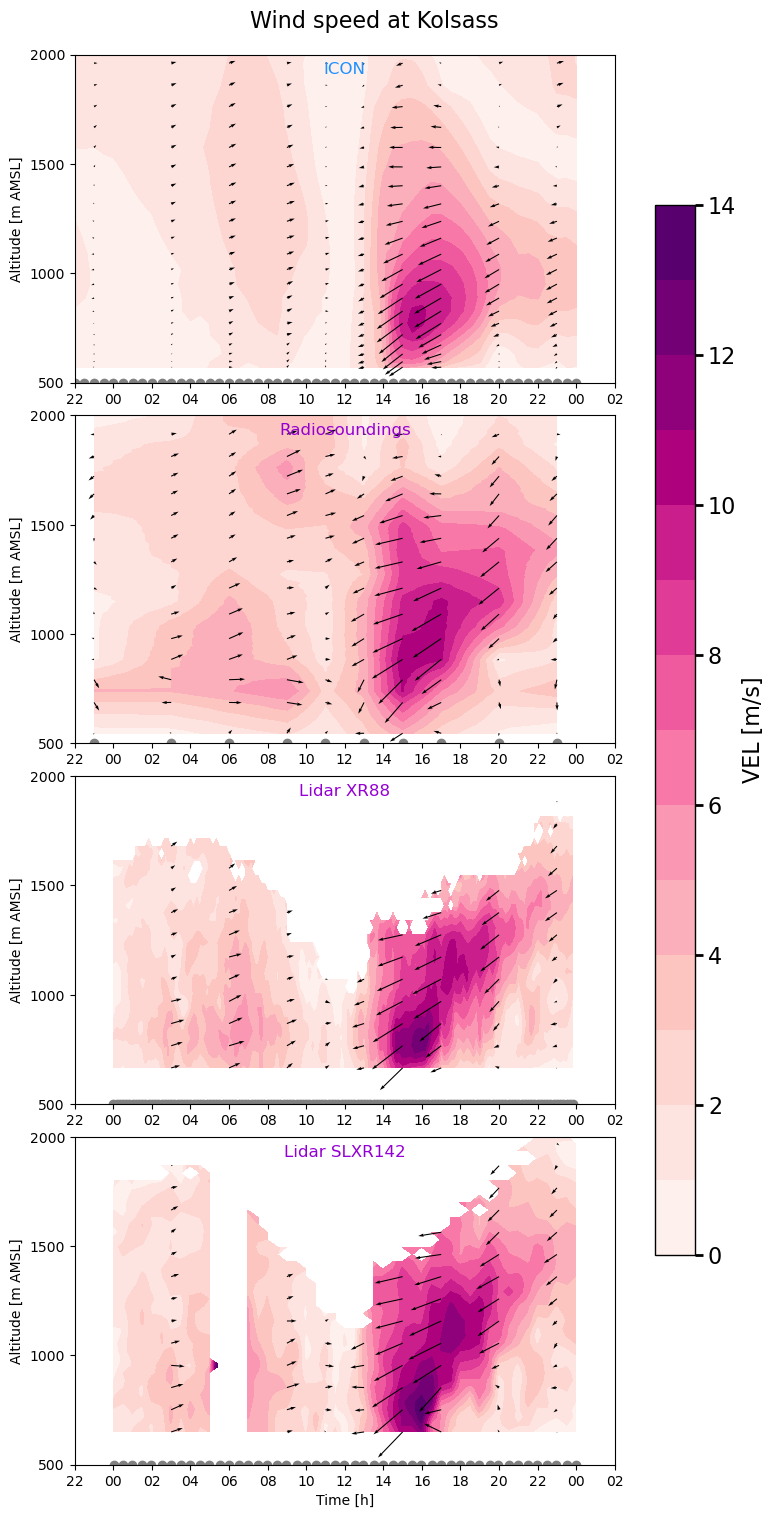

In [ ]:
## PLOT 4 LIDAR PLOT MODEL + RS + 2 LIDARS ##
# with windbarbs at rs locations
# select variable
pvar=vf.VEL

# vertical range
zmin = 500
zmax = 2000
altitudes = np.arange(500,2001,500)

# time range
startdate_plot = dt.datetime(2019,9,12,22,00)
enddate_plot = dt.datetime(2019,9,14,2,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# colorscale levels
levels = np.arange(pvar.min,pvar.max,pvar.ticks)
# h2500
if zmax == 2000:
        if pvar.name == 'T':
                levels = np.arange(285,306,2)
        if pvar.name == 'VEL':
                levels = np.arange(0,15,1)

# figure settings
fig, (ax1, ax2, ax3,ax4) = plt.subplots(4,1, figsize=(8,15))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.95,hspace=0.1)
fig.suptitle(pvar.title+' at '+loc.name, fontsize=16)

# windbarb settings
q_scale = 30
q_width = 0.002

##################################################################################################
## MODEL ##
x1 = plotdates_model
if pvar.modlev == 80:
        y1 = htd_data_model['HFL_loc']
elif pvar.modlev == 81:
        y1 = htd_data_model['HHL_loc']
z1 = np.transpose(htd_data_model[pvar.name])

# colormap
cf = ax1.contourf(x1,y1,z1, levels = levels, cmap=pvar.cmap)

# windbarbs
# data for windbarbs: only at sounding timesteps
# get index of rs dates
barb_index_model=[plotdates_model.get_loc(pdate_rs)for pdate_rs in plotdates_rs]
# select data
x1_wind = plotdates_rs
y1_wind = htd_data_model['HFL_loc'] 
x1_wind, y1_wind = np.meshgrid(x1_wind,y1_wind)
u1 = np.transpose(htd_data_model['U'])[:,barb_index_model]
v1 = np.transpose(htd_data_model['V'])[:,barb_index_model]
# plot windbarbs
dx1 = 6 # dx/2= hours for model
dy1 = 2
ax1.quiver(x1_wind, y1_wind, u1, v1, 
        scale=q_scale, scale_units='inches', width=q_width)   
  
# datapoints
ax1.scatter(plotdates_model,np.full((len(plotdates_model),1),500),color='grey')

# plotting options
ax1.set_ylim(zmin,zmax)
ax1.set_xlim(startdate_plot,enddate_plot)
# ax1.grid()
ax1.set_title('ICON', y=1.0, pad=-14,color='dodgerblue')
# ax1.set_xlabel('Time [h]')
ax1.set_xticks(plotdates_plot)
ax1.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax1.set_ylabel('Altitude [m AMSL]')
ax1.set_yticks(altitudes)

##################################################################################################
## OBS RS ##
# set data
x2 = plotdates_rs
y2 = htd_data_rs['ALT'][0]
z2 = np.transpose(htd_data_rs[pvar.name])
u2 = np.transpose(htd_data_rs['U'])
v2 = np.transpose(htd_data_rs['V'])

#create plot
# colormap
cf = ax2.contourf(x2,y2,z2, levels = levels, cmap=pvar.cmap)
# windbarbs 
dy2 = 10 # large distance for rs
ax2.quiver(x2, y2[::dy2], u2[::dy2, :], v2[::dy2, :], 
        scale=q_scale, scale_units='inches', width=q_width)
# datapoints
ax2.scatter(plotdates_rs,np.full((len(plotdates_rs),1),500),color='grey')

# plotting options
ax2.set_ylim(zmin,zmax)
ax2.set_xlim(startdate_plot,enddate_plot)
# ax2.grid()
ax2.set_title('Radiosoundings', y=1.0, pad=-14,color='darkviolet')
# ax2.set_xlabel('Time [h]')
ax2.set_xticks(plotdates_plot)
ax2.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax2.set_ylabel('Altitude [m AMSL]')
ax2.set_yticks(altitudes)

##################################################################################################
## OBS lidar SL88 ##
# set data

x3 = htd_data_lidar_SL88.time
y3 = htd_data_lidar_SL88.height
x3, y3 = np.meshgrid(x3,y3)
z3 = htd_data_lidar_SL88.VEL
# colormap
cf = ax3.contourf(x3,y3,z3, levels = levels, cmap=pvar.cmap)

# windbarbs
# data for windbarbs: only at sounding timesteps
# get index of rs dates
plotdates_SL88 = pd.to_datetime(htd_data_lidar_SL88.time)
barb_index_SL88=[plotdates_SL88.get_loc(pdate_rs)for pdate_rs in plotdates_rs[1:10]]
# select data
x3_wind = plotdates_rs[1:10]
y3_wind = htd_data_lidar_SL88.height
x3_wind, y3_wind = np.meshgrid(x3_wind,y3_wind)
u3 = htd_data_lidar_SL88.u.data[:,barb_index_SL88]
v3= htd_data_lidar_SL88.v.data[:,barb_index_SL88]
# windbarbs 
dx3 = 1
dy3 = 3
ax3.quiver(x3_wind[::dy3,::dx3], y3_wind[::dy3,::dx3], 
        u3[::dy3,::dx3], #U
        v3[::dy3,::dx3], #V
        scale=q_scale, scale_units='inches',
        width=q_width)

# datapoints
ax3.scatter(plotdates_SL88,np.full((len(plotdates_SL88),1),500),color='grey')

# plotting options
ax3.set_ylim(zmin,zmax)
ax3.set_xlim(startdate_plot,enddate_plot)
# ax3.grid()
ax3.set_title('Lidar XR88', y=1.0, pad=-14,color='darkviolet')
# ax3.set_xlabel('Time [h]')
ax3.set_xticks(plotdates_plot)
ax3.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax3.set_ylabel('Altitude [m AMSL]')
ax3.set_yticks(altitudes)

##################################################################################################
## OBS lidar SLXR142 ##
# set data

x4 = htd_data_lidar_SLXR142.time
y4 = htd_data_lidar_SLXR142.height
x4, y4 = np.meshgrid(x4,y4)
z4 = htd_data_lidar_SLXR142.VEL
# colormap
cf = ax4.contourf(x4,y4,z4, levels = levels, cmap=pvar.cmap)

# windbarbs
# data for windbarbs: only at sounding timesteps
# get index of rs dates
plotdates_SLXR142 = pd.to_datetime(htd_data_lidar_SLXR142.time)
# modify datetime to match 0:58 format in SLXR142 lidar
# plotdates_rs_mod = [pdate_rs - dt.timedelta(minutes=2) for pdate_rs in plotdates_rs]
# barb_index_SLXR142=[plotdates_SLXR142.get_loc(pdate_rs)for pdate_rs in plotdates_rs_mod[1:10]]
barb_index_SLXR142=[6,12,18,22,26,30,34,40,46]
# select data
x4_wind = plotdates_rs[1:10]
y4_wind = htd_data_lidar_SLXR142.height
x4_wind, y4_wind = np.meshgrid(x4_wind,y4_wind)
u4 = htd_data_lidar_SLXR142.u.data[:,barb_index_SLXR142]
v4= htd_data_lidar_SLXR142.v.data[:,barb_index_SLXR142]
# windbarbs 
dx4 = 1
dy4 = 3
ax4.quiver(x4_wind[::dy3,::dx3], y4_wind[::dy3,::dx3], 
        u4[::dy3,::dx3], #U
        v4[::dy3,::dx3], #V
        scale=q_scale, scale_units='inches',
        width=q_width)

# datapoints
ax4.scatter(plotdates_SLXR142,np.full((len(plotdates_SLXR142),1),500),color='grey')

# plotting options
ax4.set_ylim(zmin,zmax)
ax4.set_xlim(startdate_plot,enddate_plot)
# ax4.grid()
ax4.set_title('Lidar SLXR142', y=1.0, pad=-14,color='darkviolet')
ax4.set_xlabel('Time [h]')
ax4.set_xticks(plotdates_plot)
ax4.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax4.set_ylabel('Altitude [m AMSL]')
ax4.set_yticks(altitudes)


##################################################################################################
# add colorbar 
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cf, cax=cbar_ax)
# cbar = plt.colorbar(cf,orientation='vertical')
cbar.ax.tick_params(labelsize=16,width=2,length=6)
cbar.set_label(pvar.name+' '+pvar.units,fontsize=16)
cbar.outline.set_linewidth(1)

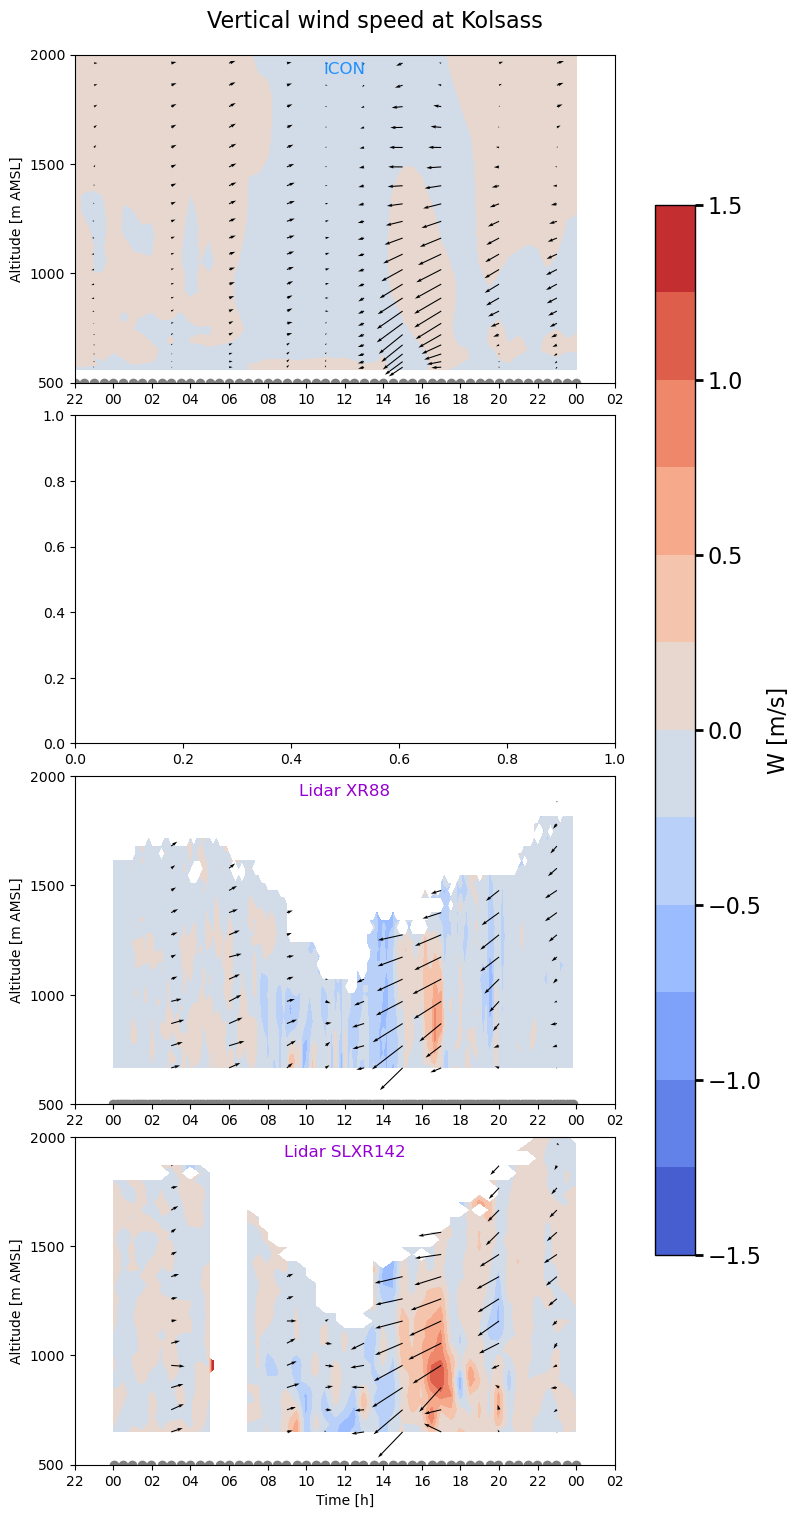

In [ ]:
## PLOT 3 LIDAR PLOT MODEL + 2 LIDARS ##
### W ###
# with windbarbs at rs locations
# select variable
pvar=vf.W

# vertical range
zmin = 500
zmax = 2000
altitudes = np.arange(500,2001,500)

# time range
startdate_plot = dt.datetime(2019,9,12,22,00)
enddate_plot = dt.datetime(2019,9,14,2,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# colorscale levels
levels = np.arange(pvar.min,pvar.max,pvar.ticks)
# h2500
if zmax == 2000:
        if pvar.name == 'T':
                levels = np.arange(285,306,2)
        if pvar.name == 'VEL':
                levels = np.arange(0,15,1)
        if pvar.name == 'W':
                levels = np.arange(-1.5,1.6,0.25)

# figure settings
fig, (ax1, ax2,ax3, ax4) = plt.subplots(4,1, figsize=(8,15))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.95,hspace=0.1)
fig.suptitle(pvar.title+' at '+loc.name, fontsize=16)

# windbarb settings
q_scale = 30
q_width = 0.002

##################################################################################################
## MODEL ##
x1 = plotdates_model
if pvar.modlev == 80:
        y1 = htd_data_model['HFL_loc']
elif pvar.modlev == 81:
        y1 = htd_data_model['HHL_loc']
z1 = np.transpose(htd_data_model[pvar.name])

# colormap
cf = ax1.contourf(x1,y1,z1, levels = levels, cmap=pvar.cmap)

# windbarbs
# data for windbarbs: only at sounding timesteps
# get index of rs dates
barb_index_model=[plotdates_model.get_loc(pdate_rs)for pdate_rs in plotdates_rs]
# select data
x1_wind = plotdates_rs
y1_wind = htd_data_model['HFL_loc'] 
x1_wind, y1_wind = np.meshgrid(x1_wind,y1_wind)
u1 = np.transpose(htd_data_model['U'])[:,barb_index_model]
v1 = np.transpose(htd_data_model['V'])[:,barb_index_model]
# plot windbarbs
dx1 = 6 # dx/2= hours for model
dy1 = 2
ax1.quiver(x1_wind, y1_wind, u1, v1, 
        scale=q_scale, scale_units='inches', width=q_width)   
  
# datapoints
ax1.scatter(plotdates_model,np.full((len(plotdates_model),1),500),color='grey')

# plotting options
ax1.set_ylim(zmin,zmax)
ax1.set_xlim(startdate_plot,enddate_plot)
# ax1.grid()
ax1.set_title('ICON', y=1.0, pad=-14,color='dodgerblue')
# ax1.set_xlabel('Time [h]')
ax1.set_xticks(plotdates_plot)
ax1.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax1.set_ylabel('Altitude [m AMSL]')
ax1.set_yticks(altitudes)

##################################################################################################
## empty ax3 ##
# ax2.set_yticks(False)

##################################################################################################
## OBS lidar SL88 ##
# set data

x3 = htd_data_lidar_SL88.time
y3 = htd_data_lidar_SL88.height
x3, y3 = np.meshgrid(x3,y3)
z3 = htd_data_lidar_SL88.w
# colormap
cf = ax3.contourf(x3,y3,z3, levels = levels, cmap=pvar.cmap)

# windbarbs
# data for windbarbs: only at sounding timesteps
# get index of rs dates
plotdates_SL88 = pd.to_datetime(htd_data_lidar_SL88.time)
barb_index_SL88=[plotdates_SL88.get_loc(pdate_rs)for pdate_rs in plotdates_rs[1:10]]
# select data
x3_wind = plotdates_rs[1:10]
y3_wind = htd_data_lidar_SL88.height
x3_wind, y3_wind = np.meshgrid(x3_wind,y3_wind)
u3 = htd_data_lidar_SL88.u.data[:,barb_index_SL88]
v3= htd_data_lidar_SL88.v.data[:,barb_index_SL88]
# windbarbs 
dx3 = 1
dy3 = 3
ax3.quiver(x3_wind[::dy3,::dx3], y3_wind[::dy3,::dx3], 
        u3[::dy3,::dx3], #U
        v3[::dy3,::dx3], #V
        scale=q_scale, scale_units='inches',
        width=q_width)

# datapoints
ax3.scatter(plotdates_SL88,np.full((len(plotdates_SL88),1),500),color='grey')

# plotting options
ax3.set_ylim(zmin,zmax)
ax3.set_xlim(startdate_plot,enddate_plot)
# ax3.grid()
ax3.set_title('Lidar XR88', y=1.0, pad=-14,color='darkviolet')
# ax3.set_xlabel('Time [h]')
ax3.set_xticks(plotdates_plot)
ax3.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax3.set_ylabel('Altitude [m AMSL]')
ax3.set_yticks(altitudes)

##################################################################################################
## OBS lidar SLXR142 ##
# set data

x4 = htd_data_lidar_SLXR142.time
y4 = htd_data_lidar_SLXR142.height
x4, y4 = np.meshgrid(x4,y4)
z4 = htd_data_lidar_SLXR142.w
# colormap
cf = ax4.contourf(x4,y4,z4, levels = levels, cmap=pvar.cmap)

# windbarbs
# data for windbarbs: only at sounding timesteps
# get index of rs dates
plotdates_SLXR142 = pd.to_datetime(htd_data_lidar_SLXR142.time)
# modify datetime to match 0:58 format in SLXR142 lidar
# plotdates_rs_mod = [pdate_rs - dt.timedelta(minutes=2) for pdate_rs in plotdates_rs]
# barb_index_SLXR142=[plotdates_SLXR142.get_loc(pdate_rs)for pdate_rs in plotdates_rs_mod[1:10]]
barb_index_SLXR142=[6,12,18,22,26,30,34,40,46]
# select data
x4_wind = plotdates_rs[1:10]
y4_wind = htd_data_lidar_SLXR142.height
x4_wind, y4_wind = np.meshgrid(x4_wind,y4_wind)
u4 = htd_data_lidar_SLXR142.u.data[:,barb_index_SLXR142]
v4= htd_data_lidar_SLXR142.v.data[:,barb_index_SLXR142]
# windbarbs 
dx4 = 1
dy4 = 3
ax4.quiver(x4_wind[::dy3,::dx3], y4_wind[::dy3,::dx3], 
        u4[::dy3,::dx3], #U
        v4[::dy3,::dx3], #V
        scale=q_scale, scale_units='inches',
        width=q_width)

# datapoints
ax4.scatter(plotdates_SLXR142,np.full((len(plotdates_SLXR142),1),500),color='grey')

# plotting options
ax4.set_ylim(zmin,zmax)
ax4.set_xlim(startdate_plot,enddate_plot)
# ax4.grid()
ax4.set_title('Lidar SLXR142', y=1.0, pad=-14,color='darkviolet')
ax4.set_xlabel('Time [h]')
ax4.set_xticks(plotdates_plot)
ax4.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax4.set_ylabel('Altitude [m AMSL]')
ax4.set_yticks(altitudes)


##################################################################################################
# add colorbar 
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cf, cax=cbar_ax)
# cbar = plt.colorbar(cf,orientation='vertical')
cbar.ax.tick_params(labelsize=16,width=2,length=6)
cbar.set_label(pvar.name+' '+pvar.units,fontsize=16)
cbar.outline.set_linewidth(1)

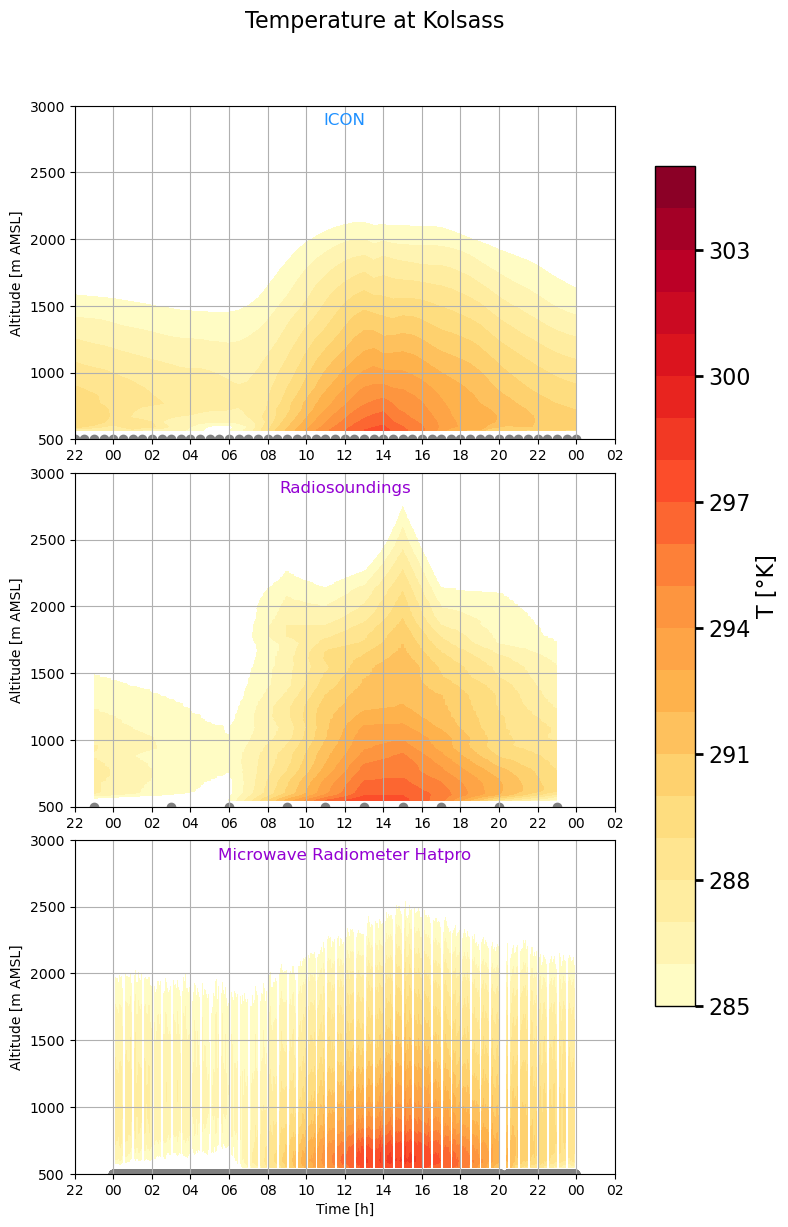

In [ ]:
## PLOT 3 LIDAR PLOT MODEL + RS + HATPRO LIDARS ##
### T; QV ###
# with windbarbs at rs locations

pvar=vf.T

# vertical range
zmin = 500
zmax = 3000
altitudes = np.arange(zmin,zmax+1,500)

# time range
startdate_plot = dt.datetime(2019,9,12,22,00)
enddate_plot = dt.datetime(2019,9,14,2,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# colorscale levels
levels = np.arange(pvar.min,pvar.max,pvar.ticks)
# h2500
if zmax == 3000:
        if pvar.name == 'T':
                levels = np.arange(285,306,1)
        if pvar.name == 'VEL':
                levels = np.arange(0,15,1)

# figure settings
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,12))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9,hspace=0.1)
fig.suptitle(pvar.title+' at '+loc.name, fontsize=16)

# windbarb settings
q_scale = 30
q_width = 0.002

##################################################################################################
## MODEL ##
x1 = plotdates_model
if pvar.modlev == 80:
        y1 = htd_data_model['HFL_loc']
elif pvar.modlev == 81:
        y1 = htd_data_model['HHL_loc']
z1 = np.transpose(htd_data_model[pvar.name])

# colormap
cf = ax1.contourf(x1,y1,z1, levels = levels, cmap=pvar.cmap)
# datapoints
ax1.scatter(plotdates_model,np.full((len(plotdates_model),1),500),color='grey')

# plotting options
ax1.set_ylim(zmin,zmax)
ax1.set_xlim(startdate_plot,enddate_plot)
ax1.grid()
ax1.set_title('ICON', y=1.0, pad=-14,color='dodgerblue')
# ax1.set_xlabel('Time [h]')
ax1.set_xticks(plotdates_plot)
ax1.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax1.set_ylabel('Altitude [m AMSL]')
ax1.set_yticks(altitudes)

##################################################################################################
## OBS RS ##
# set data
x2 = plotdates_rs
y2 = htd_data_rs['ALT'][0]
z2 = np.transpose(htd_data_rs[pvar.name])
u2 = np.transpose(htd_data_rs['U'])
v2 = np.transpose(htd_data_rs['V'])

#create plot
# colormap
cf = ax2.contourf(x2,y2,z2, levels = levels, cmap=pvar.cmap)
# datapoints
ax2.scatter(plotdates_rs,np.full((len(plotdates_rs),1),500),color='grey')

# plotting options
ax2.set_ylim(zmin,zmax)
ax2.set_xlim(startdate_plot,enddate_plot)
ax2.grid()
ax2.set_title('Radiosoundings', y=1.0, pad=-14,color='darkviolet')
# ax2.set_xlabel('Time [h]')
ax2.set_xticks(plotdates_plot)
ax2.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax2.set_ylabel('Altitude [m AMSL]')
ax2.set_yticks(altitudes)

##################################################################################################
## OBS HATPRo ##
# set data

x3 = htd_data_lidar_hatpro.time
y3 = htd_data_lidar_hatpro.height+547
x3, y3 = np.meshgrid(x3,y3)
z3 = htd_data_lidar_hatpro.ta
# colormap
cf = ax3.contourf(x3,y3,z3, levels = levels, cmap=pvar.cmap)

# windbarbs
# data for windbarbs: only at sounding timesteps
# get index of rs dates
plotdates_hatpro = pd.to_datetime(htd_data_lidar_hatpro.time)

# datapoints
ax3.scatter(plotdates_hatpro,np.full((len(plotdates_hatpro),1),500),color='grey')

# plotting options
ax3.set_ylim(zmin,zmax)
ax3.set_xlim(startdate_plot,enddate_plot)
ax3.grid()
ax3.set_title('Microwave Radiometer Hatpro', y=1.0, pad=-14,color='darkviolet')
ax3.set_xlabel('Time [h]')
ax3.set_xticks(plotdates_plot)
ax3.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax3.set_ylabel('Altitude [m AMSL]')
ax3.set_yticks(altitudes)

##################################################################################################
# add colorbar 
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cf, cax=cbar_ax)
# cbar = plt.colorbar(cf,orientation='vertical')
cbar.ax.tick_params(labelsize=16,width=2,length=6)
cbar.set_label(pvar.name+' '+pvar.units,fontsize=16)
cbar.outline.set_linewidth(1)

In [ ]:
htd_data_rs['TD']

array([[  8.27397174,   9.58548524,  11.05555697, ..., -72.20205849,
        -72.20205849, -72.11312687],
       [  4.45735295,   6.20784332,   8.01330155, ..., -72.45349328,
        -72.45349328, -72.45349328],
       [  8.89345556,   9.15650944,   9.23593279, ..., -75.48269736,
        -75.56837804, -75.56837804],
       ...,
       [ 12.97286224,  13.33864033,  13.96473476, ..., -73.43351962,
        -73.52216575, -73.52216575],
       [ 11.05867417,  12.52363675,  14.27663894, ..., -72.82457983,
        -72.90164282, -72.90164282],
       [  9.64680816,  10.96374127,  12.17212373, ..., -72.63049935,
        -72.63049935, -72.63049935]])